In [8]:

!pip install seaborn


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [9]:
!which python

/home/josheren/miniconda3/bin/python


In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [11]:
!ls

catboost_info  data  playground-series-s5e10.ipynb


In [49]:
!cp ~/kaggle/kaggle.json ~/.config/kaggle
!chmod 600 ~/.config/kaggle

!python3 --version

Python 3.13.5


In [13]:
import os

COMPETITION_NAME = "playground-series-s5e10"

if not os.path.exists('./data/playground-series-s5e10.zip'):
    print("Download.")
    !kaggle competitions download -c $COMPETITION_NAME -p ./data

if not os.path.exists('./data/train.csv'):
    print("Unzip.")
    !unzip ./data/playground-series-s5e10.zip -d ./data



In [14]:
path = './data/'

train_path = path + 'train.csv'
test_path = path + 'test.csv'
submission_path = path + 'sample_submission.csv'

In [15]:
train_data = pd.read_csv(train_path)
test_data = pd.read_csv(test_path)
submission_data = pd.read_csv(submission_path)

train_data.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


In [16]:
train_data.isna().sum()

id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64

In [17]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64  
 13  accident_risk           517754 non-null  float64
dtypes: bool(4), float64(

In [18]:
cat_cols =  train_data.select_dtypes(include="object").columns
num_cols = train_data.select_dtypes(exclude=["object", "bool"]).columns
bool_cols = train_data.select_dtypes(include="bool").columns

print("Categorical ", cat_cols)
print()
print("Numeric ", num_cols)
print()
print("Bool ", bool_cols)

Categorical  Index(['road_type', 'lighting', 'weather', 'time_of_day'], dtype='object')

Numeric  Index(['id', 'num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents',
       'accident_risk'],
      dtype='object')

Bool  Index(['road_signs_present', 'public_road', 'holiday', 'school_season'], dtype='object')


In [19]:
for col in cat_cols:
    print(f"{col}: ", train_data[col].unique())

road_type:  ['urban' 'rural' 'highway']
lighting:  ['daylight' 'dim' 'night']
weather:  ['rainy' 'clear' 'foggy']
time_of_day:  ['afternoon' 'evening' 'morning']


In [20]:
label = "accident_risk"

X = train_data.drop([label], axis=1)
y = train_data[label]

In [21]:
cat_cols =  [*(X.select_dtypes(include="object").columns)]
num_cols = [*X.select_dtypes(exclude=["object", "bool"]).columns]
bool_cols = [*X.select_dtypes(include="bool").columns]

num_cols.remove("id")

print(f"Categorical {cat_cols} \n")
print(f"Numeric  {cat_cols}\n")
print(f"Bool  {cat_cols}")

Categorical ['road_type', 'lighting', 'weather', 'time_of_day'] 

Numeric  ['road_type', 'lighting', 'weather', 'time_of_day']

Bool  ['road_type', 'lighting', 'weather', 'time_of_day']


In [22]:
display(X[cat_cols])
display(X[bool_cols])
display(X[num_cols])

,road_type,lighting,weather,time_of_day
0,urban,daylight,rainy,afternoon
1,urban,daylight,clear,evening
2,rural,dim,clear,morning
3,highway,dim,rainy,morning
4,rural,daylight,foggy,evening
...,...,...,...,...
517749,highway,daylight,foggy,afternoon
517750,rural,daylight,rainy,morning
517751,urban,daylight,foggy,afternoon
517752,highway,night,clear,afternoon


,road_signs_present,public_road,holiday,school_season
0,False,True,False,True
1,True,False,True,True
2,False,True,True,False
3,True,True,False,False
4,False,False,True,False
...,...,...,...,...
517749,True,True,False,False
517750,True,True,False,False
517751,False,False,False,True
517752,True,False,True,True


,num_lanes,curvature,speed_limit,num_reported_accidents
0,2,0.06,35,1
1,4,0.99,35,0
2,4,0.63,70,2
3,4,0.07,35,1
4,1,0.58,60,1
...,...,...,...,...
517749,4,0.10,70,2
517750,4,0.47,35,1
517751,4,0.62,25,0
517752,3,0.63,25,3


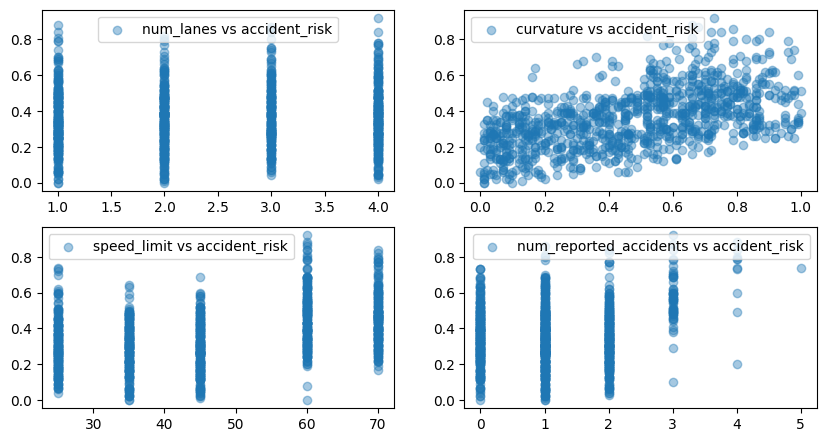

In [23]:
plt.figure(figsize=(10, 8))
for i, col in enumerate(num_cols):
    plt.subplot(3, 2, i+1)
    plt.scatter(X[col][:1000], y[:1000], label=col+" vs "+label, alpha=.4)
    plt.legend()

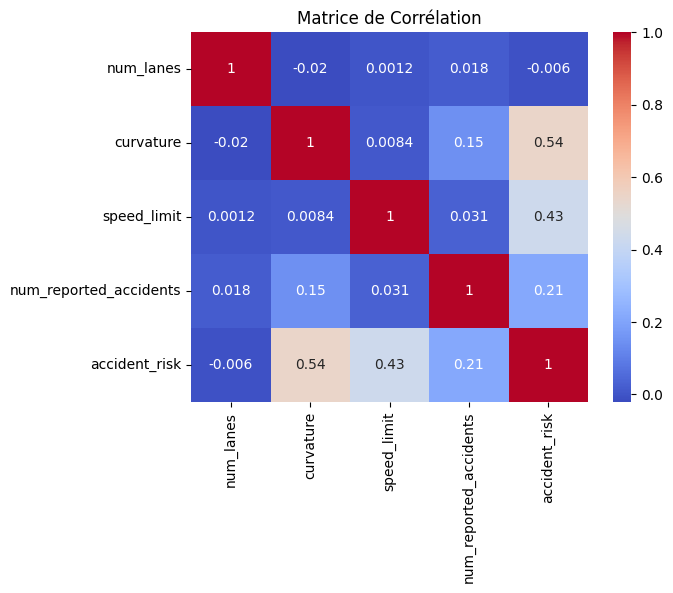

In [24]:
df = pd.concat([X[num_cols], y], axis=1)

corr = df.corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Matrice de Corrélation")
plt.show()


In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=92)

In [26]:
from sklearn.metrics import make_scorer, root_mean_squared_error

scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

# Data Preparation for training and testing

In [27]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer

def bool_to_int(X):
    return X.astype(int)

num_process = StandardScaler()
cat_process = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
bool_process = FunctionTransformer(bool_to_int)

preprocessing = ColumnTransformer(transformers=[
    ('num', num_process, num_cols),
    ('bool', bool_process, bool_cols),
    ('cat', cat_process, cat_cols),
])


In [28]:
from sklearn.pipeline import Pipeline


def build_pipeline(model, preprocessing=preprocessing):

    pipeline = Pipeline(steps=[
        ("preprocessing", preprocessing),
        ("model", model)
    ])

    return pipeline

# Model Selection

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=92)

def evaluate_model(model, X, y):
    pipeline = build_pipeline(model)
    scores = cross_val_score(pipeline, X, y, cv=kf, scoring=scorer, n_jobs=-1)
    print(f"Moyenne type pour {model}: {scores.mean()}")
    print(f"Ecart type pour {model}: {scores.std()}/n")
    return scores


In [30]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


lasso = Lasso(alpha=0.1)
ridge = Ridge(alpha=0.5)

rf = RandomForestRegressor()

xgb = XGBRegressor()
lgbm = LGBMRegressor()

In [32]:
X_val = X_train[:50_000]
y_val = y_train[:50_000]

models = {
    "lasso": lasso,
    "ridge": ridge,
    "rf": rf,
    "xgb": xgb,
    "lgbm": lgbm
}
models_scores = {}

for model_name, model in models.items():
    scores = evaluate_model(model, X_val, y_val)
    models_scores[model_name] = scores

Moyenne type pour Lasso(alpha=0.1): -0.16552502762699678
Ecart type pour Lasso(alpha=0.1): 0.0005929371230959533
Moyenne type pour Ridge(alpha=0.5): -0.07368374397295338
Ecart type pour Ridge(alpha=0.5): 0.0004407417313056608
Moyenne type pour RandomForestRegressor(): -0.05940320903374062
Ecart type pour RandomForestRegressor(): 0.0005808868610023569
Moyenne type pour XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             m

/home/josheren/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


Moyenne type pour LGBMRegressor(): -0.056679581909477125
Ecart type pour LGBMRegressor(): 0.0006391777371797693


/home/josheren/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/josheren/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/josheren/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
/home/josheren/miniconda3/lib/python3.13/site-packages/sklearn/utils/validation.py:2749: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


/tmp/ipykernel_1935/2625735483.py:3: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(models_scores.values(), labels=models_scores.keys())


{'whiskers': [<matplotlib.lines.Line2D at 0x73e906f520d0>,
 'caps': [<matplotlib.lines.Line2D at 0x73e906f52350>,
 'boxes': [<matplotlib.lines.Line2D at 0x73e906f51f90>,
 'medians': [<matplotlib.lines.Line2D at 0x73e906f525d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x73e906f52710>,
 'means': []}

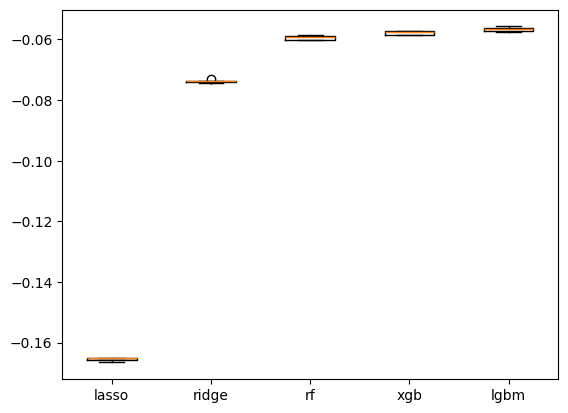

In [33]:
models_scores

plt.boxplot(models_scores.values(), labels=models_scores.keys())

# Model evaluation and validation

In [34]:
from sklearn.metrics import make_scorer, root_mean_squared_error

scorer = make_scorer(root_mean_squared_error, greater_is_better=False)

In [35]:
from sklearn.model_selection import RandomizedSearchCV

def find_best_params(model, params, cv=5, n_iter=10, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    """ Find the best model using RandomizedSearchCV on params"""
    pipeline = build_pipeline(model)

    rdcv = RandomizedSearchCV(
        pipeline, 
        param_distributions=params, 
        scoring=scorer, 
        n_jobs=-1, 
        n_iter=n_iter,
        cv=cv,
        verbose=100,
        random_state=92
    )

    rdcv.fit(X_train, y_train)

    best_model = rdcv.best_estimator_
    train_score = rdcv.best_score_
    r2_score = best_model.score(X_test, y_test)

    print("Train score:", train_score)
    print("R2 score on test:", r2_score)

    return best_model

# Preparation for kaggle submission

In [36]:
def predict_for_submit(best_model, test_data=test_data, X=X, y=y):

    best_model.fit(X, y)

    y_pred = best_model.predict(test_data)

    return y_pred

def submit(y_pred, model_name, submission_data=submission_data):

    submission = submission_data.copy()
    submission['accident_risk'] = y_pred

    file_path = f"data/submission_{model_name}.csv"
    print(file_path)
    submission.to_csv(file_path, index=False)


    !kaggle competitions submit -c $COMPETITION_NAME -f $file_path -m "{model_name} submission"



# Model Training for submission

### XGBoost Model

In [43]:
from xgboost import XGBRegressor

xgb = "XGB"

model = XGBRegressor(
    eval_metric='rmse', 
    scale_pos_weight=1,                      
    random_state=92,
    n_jobs=-1,
    verbosity=1
)


xgb_params = {
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2],       
    'model__max_depth': [4, 6, 8, 10],                   
    'model__max_leaves': [0, 31, 63, 127],                 
    'model__n_estimators': [500, 1000, 2000],             
    'model__reg_alpha': [0, 0.01, 0.1, 1],               
    'model__reg_lambda': [1, 1.5, 2, 3],                  
    'model__subsample': [0.6, 0.8, 1.0],                      
}

xgb_best_model = find_best_params(model, xgb_params)

y_pred_xgb = predict_for_submit(xgb_best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 3/5; 1/10] START model__learning_rate=0.05, model__max_depth=10, model__max_leaves=31, model__n_estimators=500, model__reg_alpha=1, model__reg_lambda=2, model__subsample=0.6
[CV 2/5; 1/10] START model__learning_rate=0.05, model__max_depth=10, model__max_leaves=31, model__n_estimators=500, model__reg_alpha=1, model__reg_lambda=2, model__subsample=0.6
[CV 1/5; 1/10] START model__learning_rate=0.05, model__max_depth=10, model__max_leaves=31, model__n_estimators=500, model__reg_alpha=1, model__reg_lambda=2, model__subsample=0.6
[CV 4/5; 1/10] START model__learning_rate=0.05, model__max_depth=10, model__max_leaves=31, model__n_estimators=500, model__reg_alpha=1, model__reg_lambda=2, model__subsample=0.6
[CV 5/5; 1/10] START model__learning_rate=0.05, model__max_depth=10, model__max_leaves=31, model__n_estimators=500, model__reg_alpha=1, model__reg_lambda=2, model__subsample=0.6
[CV 1/5; 2/10] START model__learning_rate=0.1, mo

In [41]:
import joblib

joblib.dump(xgb_best_model, "xgb.joblib")

['xgb.joblib']

### LGM model

In [45]:
from lightgbm import LGBMRegressor

lgbm = "LGBM"

model = LGBMRegressor(
    eval_metric='rmse', 
    scale_pos_weight=1,                      
    random_state=92,
    n_jobs=-1,
    verbosity=1
)


lgbm_params = {
    'model__learning_rate': [0.01, 0.02, 0.05],
    'model__max_depth': [6, 10, 16],  
    'model__n_estimators': [500, 1000, 2000],
    'model__num_leaves': [31, 63, 127],
    'model__reg_alpha': [0.1, 0.5, 1],
    'model__reg_lambda': [0.1, 0.5, 1],
    'model__subsample': [0.7, 0.8, 0.9], 
    'model__colsample_bytree': [0.7, 0.8, 1.0],
    'model__min_child_samples': [20, 100, 300]
}


lgbm_best_model = find_best_params(model, lgbm_params)
y_pred_lgbm = predict_for_submit(lgbm_best_model)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[CV 1/5; 1/10] START model__colsample_bytree=0.7, model__learning_rate=0.02, model__max_depth=16, model__min_child_samples=300, model__n_estimators=1000, model__num_leaves=31, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.7
[CV 2/5; 1/10] START model__colsample_bytree=0.7, model__learning_rate=0.02, model__max_depth=16, model__min_child_samples=300, model__n_estimators=1000, model__num_leaves=31, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.7
[CV 4/5; 1/10] START model__colsample_bytree=0.7, model__learning_rate=0.02, model__max_depth=16, model__min_child_samples=300, model__n_estimators=1000, model__num_leaves=31, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.7
[CV 3/5; 1/10] START model__colsample_bytree=0.7, model__learning_rate=0.02, model__max_depth=16, model__min_child_samples=300, model__n_estimators=1000, model__num_leaves=31, model__reg_alpha=0.1, model__reg_lambda=1, model__subsample=0.7
[CV 5/5; 1/10] START model__colsample_by

KeyboardInterrupt: 

# Submission for kaggle

In [47]:
!pip install kaggle

  Using cached kaggle-1.7.4.5-py3-none-any.whl.metadata (16 kB)
  Using cached bleach-6.2.0-py3-none-any.whl.metadata (30 kB)
  Using cached protobuf-6.32.1-cp39-abi3-manylinux2014_x86_64.whl.metadata (593 bytes)
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
  Using cached webencodings-0.5.1-py2.py3-none-any.whl.metadata (2.1 kB)
Using cached kaggle-1.7.4.5-py3-none-any.whl (181 kB)
Using cached bleach-6.2.0-py3-none-any.whl (163 kB)
Using cached protobuf-6.32.1-cp39-abi3-manylinux2014_x86_64.whl (322 kB)
Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
Using cached webencodings-0.5.1-py2.py3-none-any.whl (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [kaggle]2m5/6 [kaggle]f]


In [50]:
submit(y_pred_xgb, xgb)

data/submission_XGB.csv
Traceback (most recent call last):
  File "/home/josheren/miniconda3/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/home/josheren/miniconda3/lib/python3.13/site-packages/kaggle/__init__.py", line 6, in <module>
    api.authenticate()
    ~~~~~~~~~~~~~~~~^^
  File "/home/josheren/miniconda3/lib/python3.13/site-packages/kaggle/api/kaggle_api_extended.py", line 434, in authenticate
    raise IOError('Could not find {}. Make sure it\'s located in'
    ...<3 lines>...
                      self.config_file, self.config_dir))
OSError: Could not find kaggle.json. Make sure it's located in /home/josheren/.config/kaggle. Or use the environment method. See setup instructions at https://github.com/Kaggle/kaggle-api/
